# sandbox.ipynb

This python notebook performs regressions on data pulled from a processed mongo DB created by GASpy. It then saves these regressions into pickles (for later use) and creates parity plots of the regression fits.

# Initialize

In [1]:
# Modify the path so that we use GASpy_dev instead of GASpy
gaspy_path = '/global/project/projectdirs/m2755/GASpy/'

In [ ]:
# Modify the path so that we use GASpy_dev instead of GASpy
#import sys
#gaspy_path = '/global/project/projectdirs/m2755/GASpy_dev/'
#sys.path.insert(0, gaspy_path)
#sys.path.insert(0, gaspy_path + '/GASpy_feedback')
#sys.path.insert(0, gaspy_path + '/GASpy_regressions')

In [2]:
# Importing
import pdb
from gaspy_regress.regressor import GASpyRegressor
from gaspy_regress import gio, plot, predict
from gaspy.utils import vasp_settings_to_str, read_rc, docs_to_pdocs
from gaspy import defaults

VASP_SETTINGS = vasp_settings_to_str({'gga': 'RP',
                                      'pp_version': '5.4',
                                      'encut': 350})

# Regress

In [3]:
import copy
from tpot import TPOTRegressor

In [4]:
model_name = 'TPOT'
features = ['coordatoms_chemfp0', 'neighbors_chemfp0']
responses = ['energy']
blocks = ['adsorbate']

In [ ]:
tpot = TPOTRegressor(
                     generations=1,
                     population_size=16,
                     offspring_size=16,
                     verbosity=2,
                     random_state=42,
                     scoring='neg_median_absolute_error',
                     #n_jobs=16,
                    )

H = GASpyRegressor(features=features, responses=responses,
                   blocks=blocks, vasp_settings=VASP_SETTINGS,
                   #train_size=0.8, dev_size=0.1)
                   #train_size=0.9)
                   train_size=1)

fit_blocks = [('CO',), ('H',)]
#fit_blocks = [('CO',)]
#fit_blocks = None

H.fit_tpot(tpot, model_name=model_name, blocks=fit_blocks)

In [ ]:
gio.dump_model(H)

In [5]:
H = gio.load_model(model_name, features, responses, blocks)

In [6]:
H.print_performance_metric('RMSE')

RMSE values:
	('H',)
		all
			0.216458967029
		train
			0.216458967029
	('CO',)
		all
			0.143074995113
		train
			0.143074995113


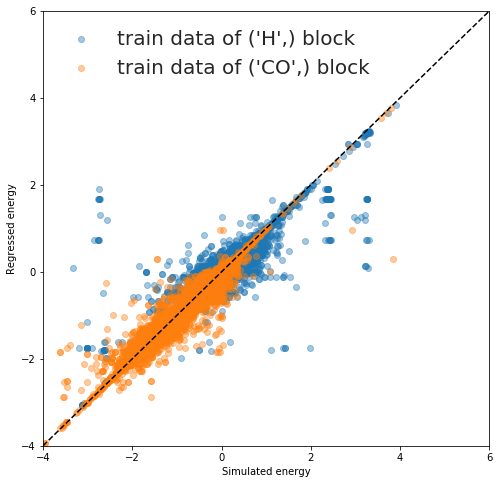

In [7]:
x, y, text = H.parity_plot(plotter='matplotlib', split=True, figsize=(8, 8), alpha=0.4)

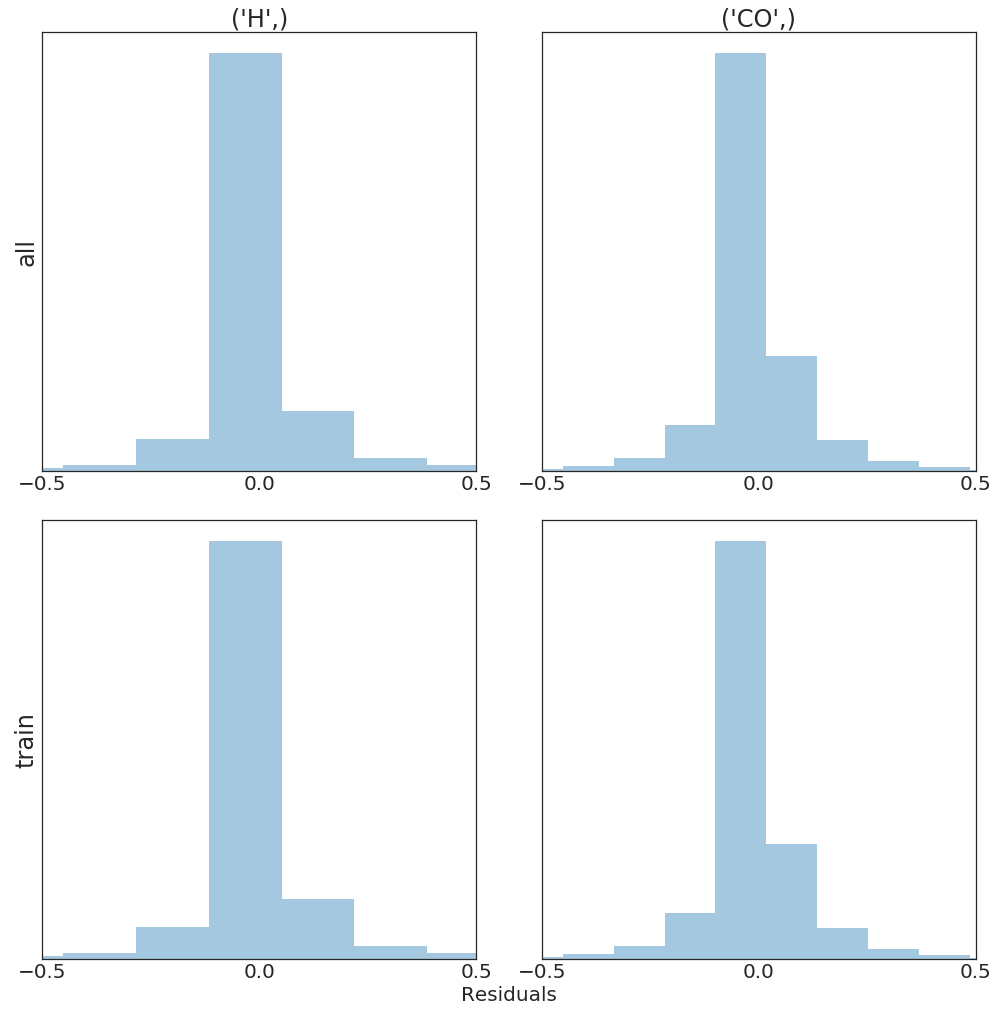

In [8]:
H.residual_plot(xlim=[-0.5, 0.5], xticks=[-0.5, 0, 0.5])

# Predict

In [9]:
regressor = H
excel_file_path = read_rc()['gaspy_path'] + '/GASpy_regressions/volcanos_parsed.xlsx'

## CO$_2$ Reduction

In [10]:
regressor_block = ('CO',)
adsorbate = 'CO'
system = 'CO2RR'
scale = 'log'

In [ ]:
co2_data = predict.volcano(H, regressor_block, system,excel_file_path,
                           scale, adsorbate, processes=4)

In [ ]:
gio.dump_predictions(co2_data, regressor=H, system=system)

In [11]:
co2_data = gio.load_predictions(model_name, features, responses, blocks, system)

In [ ]:
plot.volcano(co2_data, excel_file_path, system, scale)

In [ ]:
plot.filtered_parity(co2_data, scale=scale, plot_type='matplotlib', plot_range=[0.01, 14],
                     x_label='DFT-predicted activity [mA/cm2]',
                     y_label='ML-estimated activity [mA/cm2]',
                     title='Activity on surface minima')

In [ ]:
plot.filtered_parity(co2_data, scale=scale, plot_type='plotly', plot_range=[0.01, 14],
                     x_label='DFT-predicted activity [mA/cm2]',
                     y_label='ML-estimated activity [mA/cm2]',
                     title='Activity on surface minima')

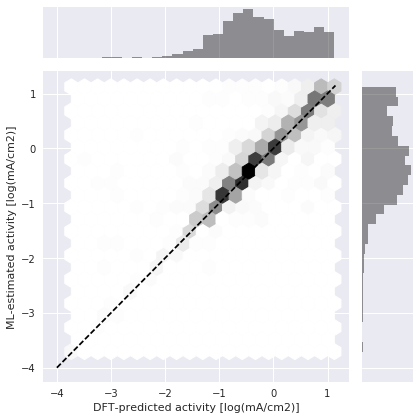

In [12]:
plot.filtered_parity(co2_data, scale=scale, plot_type='hex', plot_range=[0.0001, 14],
                     save=True,
                     x_label='DFT-predicted activity [log(mA/cm2)]',
                     y_label='ML-estimated activity [log(mA/cm2)]',
                     title='Activity parity on surface minima')

## HER

In [13]:
regressor_block = ('H',)
adsorbate = 'H'
system = 'HER'
scale = 'log'

In [ ]:
her_data = predict.volcano(H, regressor_block, system, excel_file_path, scale, adsorbate)

In [ ]:
gio.dump_predictions(her_data, regressor=H, system=system)

In [14]:
her_data = gio.load_predictions(model_name, features, responses, blocks, system)

In [ ]:
plot.volcano(her_data, excel_file_path, system, scale)

In [ ]:
plot.filtered_parity(her_data, scale=scale, plot_type='plotly', plot_range=[1e-12, 1e-3],
                     x_label='DFT-predicted activity [A/cm2]',
                     y_label='ML-estimated activity [A/cm2]',
                     title='Activity on surface minima')

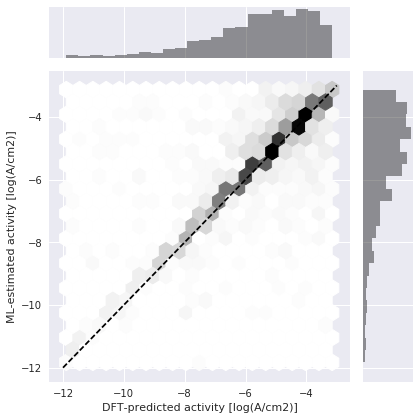

In [15]:
plot.filtered_parity(her_data, scale=scale, plot_type='hex', plot_range=[1e-12, 1e-3],
                     x_label='DFT-predicted activity [log(A/cm2)]',
                     y_label='ML-estimated activity [log(A/cm2)]',
                     title='Activity parity on surface minima')